# Necessary imports

In [36]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# Explore the data

## Read the data

In [3]:
ships = pd.read_csv('./data/train_ship_segmentations_v2.csv')
ships.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Convert *EncodedPixels* to string

In [4]:
ships['EncodedPixels'] = ships['EncodedPixels'].astype(str)

## View the shapes of the images

In [9]:
image_dir = './data/train_v2'

shapes = []
for image in tqdm(os.listdir(image_dir)):
    # ignore invalid image
    if image == '6384c3e78.jpg':
        continue
    imagefile = os.path.join(image_dir, image)
    shapes.append(cv2.imread(imagefile).shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [04:54<00:00, 40.76it/s]


In [10]:
shapes[:5]

[(768, 768, 3), (768, 768, 3), (768, 768, 3), (768, 768, 3), (768, 768, 3)]

We observe that all images have the same shape! Let's verify:

In [11]:
cnt_wrong = 0

cnt_wrong = len([shape for shape in shapes if shape != (768, 768, 3)])

print(f'#different shapes = {cnt_wrong}')

#different shapes = 0


So, all images have the same shape!

## Visualize a few images

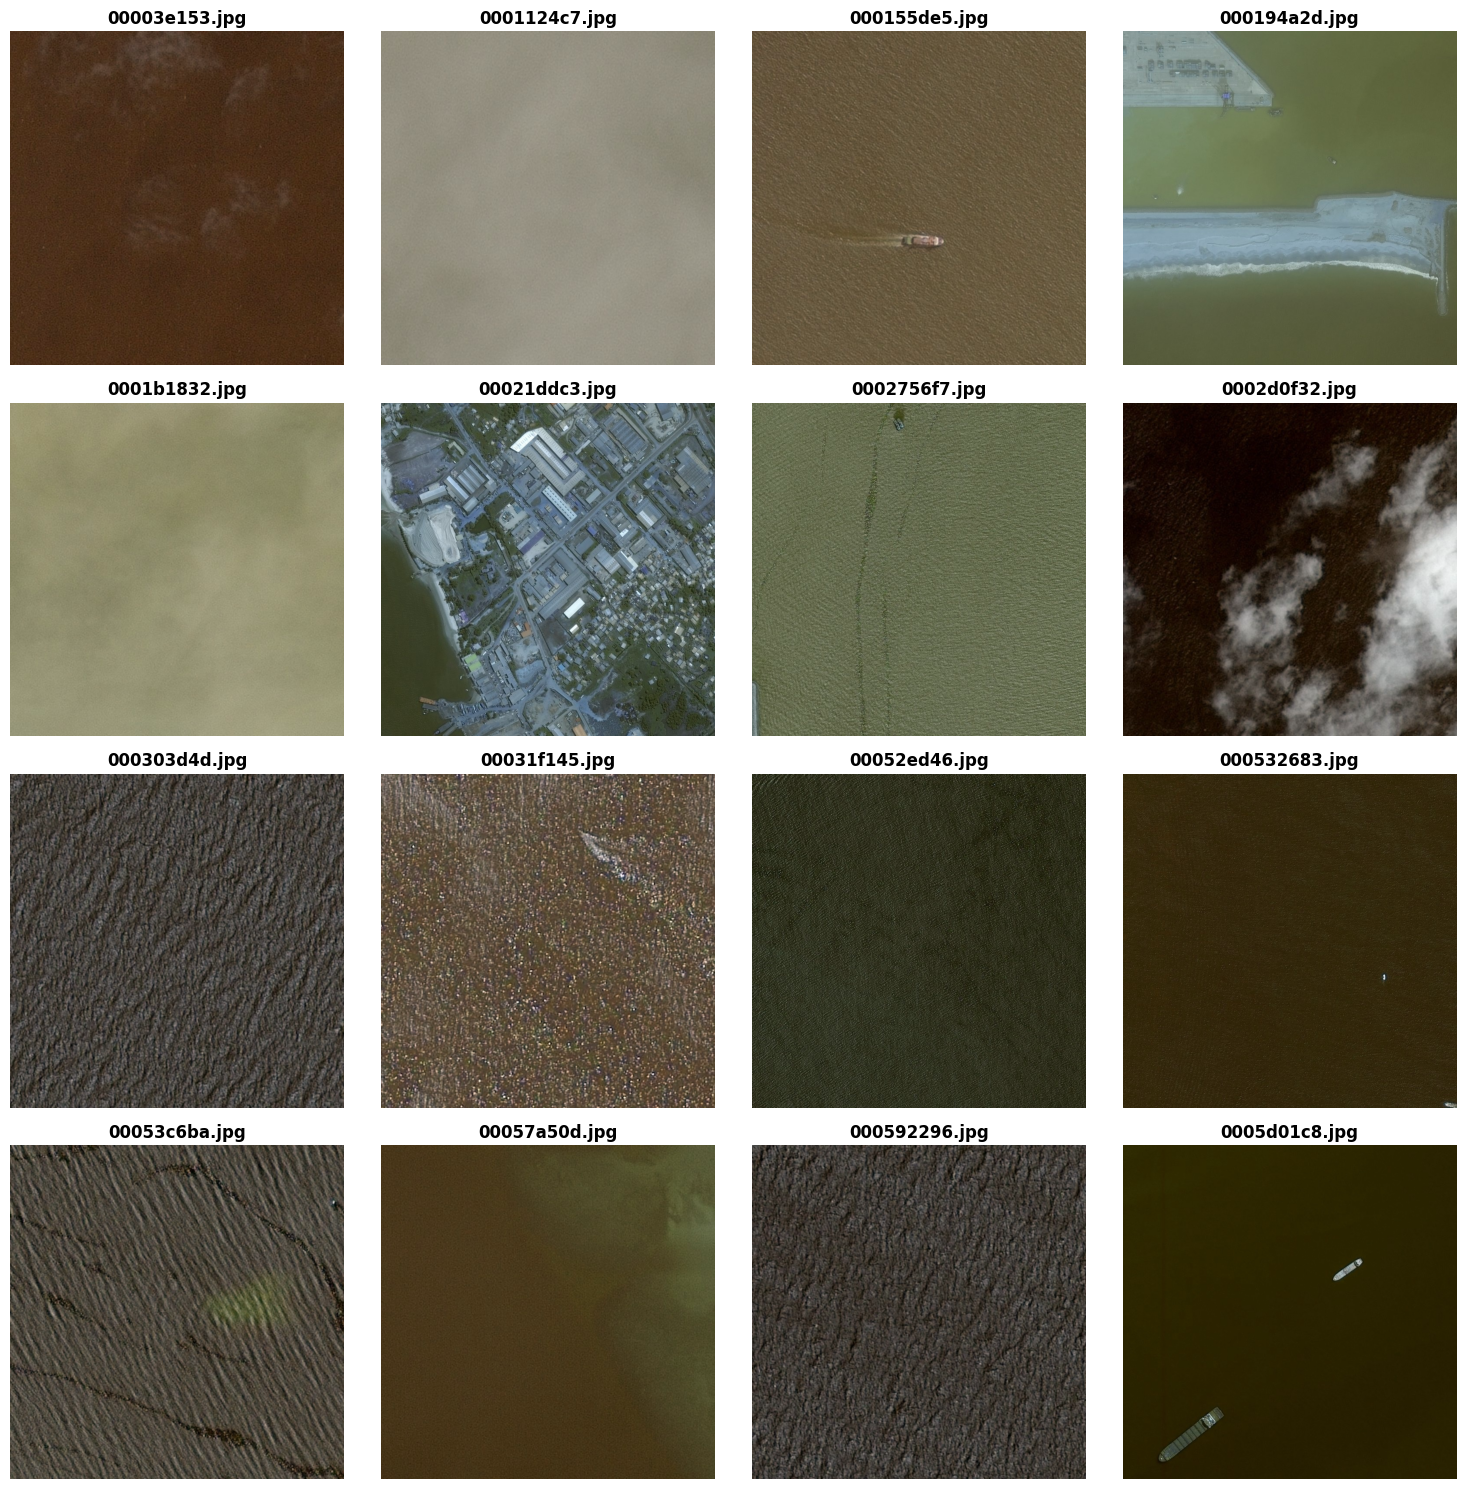

In [17]:
image_dir = './data/train_v2'

plt.figure(figsize=(15,15))
for i, image in enumerate(list(os.listdir(image_dir))[:16]):
    plt.subplot(4,4,i+1)
    plt.imshow(cv2.imread(os.path.join(image_dir, image)))
    plt.title(f"{image}", weight='bold')
    plt.axis('off')
plt.tight_layout()
plt.show()

As wee can see, not all images have ships!

## Ship statistics

In [31]:
unique_images_num = ships['ImageId'].nunique()
images_without_ships_num = ships[ships['EncodedPixels'] == 'nan'].shape[0]
print(f'#images = {unique_images_num}')
print(f'#images with ships = {unique_images_num - images_without_ships_num}')
print(f'#images with ships % = {round((unique_images_num - images_without_ships_num) / unique_images_num * 100, 2)}%')

#images = 192556
#images with ships = 42556
#images with ships % = 22.1%


So inly 22% images actually have ships.

### Distribution of the ships count

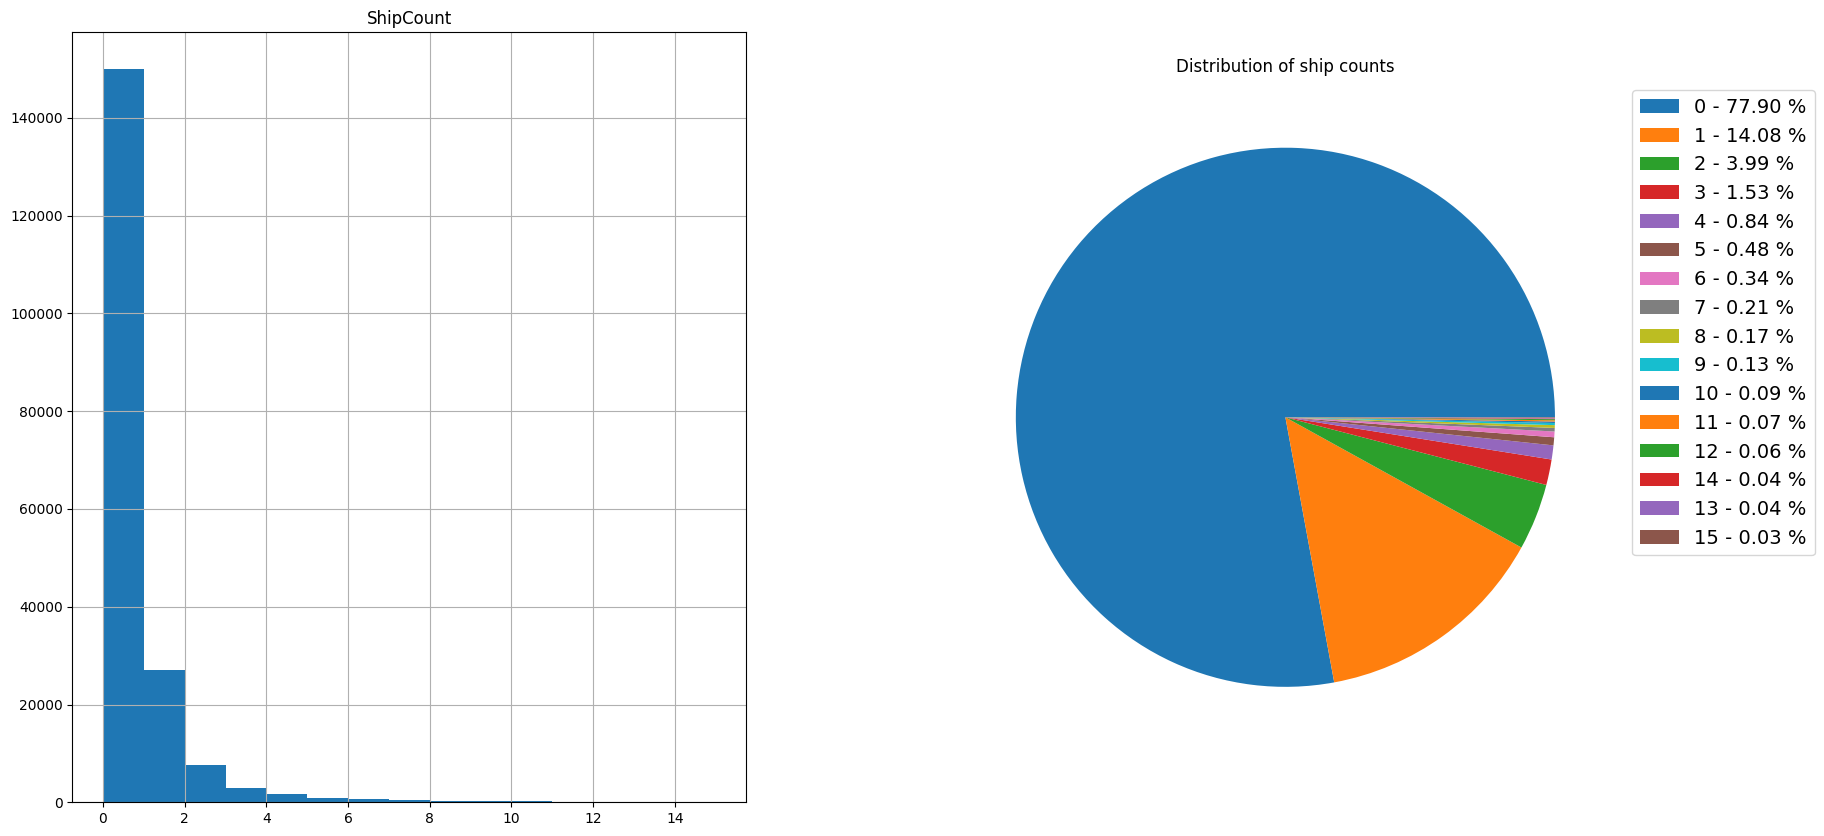

In [34]:
ships['ShipCount'] = ships.apply(lambda row: 0 if row['EncodedPixels'] == 'nan' else 1, axis=1)

# A row per one ship
ships_numbers = ships[['ImageId','ShipCount']].groupby(['ImageId']).sum()

f, ax=plt.subplots(1, 2, figsize=(20,10))

# Plot a histogram of ship counts
ships_numbers.hist(bins = 15, ax=ax[0])

y = ships_numbers.value_counts().values
percent = 100.*y/y.sum()
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(ships_numbers.value_counts().index.get_level_values(0), percent)]
# Plot pie chart of ship counts
ships_numbers.value_counts().plot.pie(labels=None, ax=ax[1])
ax[1].legend(labels, bbox_to_anchor=(1., 1.), fontsize=14)
ax[1].yaxis.set_visible(False)
ax[1].set_title('Distribution of ship counts')

plt.show()

So we have at most 155 ships per image.

## Compute the class imbalance

In [40]:
positive_class = 0

for encoding in ships['EncodedPixels']:
    if encoding == 'nan':
        continue
    encoding = np.array(encoding.split(' '), dtype='int64')
    positive_class += sum([x for i, x in enumerate(encoding) if i%2 == 1])

print(f'fraction of positive pixels = {round(positive_class / (768*768*3*unique_images_num) * 100, 2)}%')

fraction of positive pixels = 0.04%


As we can see, there is a heavy class imbalance. I am going to alleviate this issue using 2 methods:

1. Reduce the dataset keeping a large fraction of images containing ships and only a small fraction of the rest of the images.
2. Use class weights when calculating the loss.